In [25]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Ścieżka do bazy danych
db_path = "db.db"

# Połączenie z bazą danych
conn = sqlite3.connect(db_path)

# Zapytania SQL
query = "SELECT * FROM dane_miesieczne"
query2 = "SELECT * FROM instalacje"

# Wczytanie danych z bazy danych do DataFrame
dane_miesieczne = pd.read_sql_query(query, conn)
instalacje = pd.read_sql_query(query2, conn)

# Zamknięcie połączenia z bazą danych
conn.close()

# Wczytanie danych pogodowych z pliku CSV
pogoda_df = pd.read_csv('pogoda.csv', names=['id', 'miesiac', 'naslonecznienie', 'temperatura'])

# Filtrowanie instalacji o mocy większej niż 0
instalacje = instalacje[instalacje['moc'] > 0]

# Konwersja kolumny 'id' do formatu liczbowego
pogoda_df['id'] = pd.to_numeric(pogoda_df['id'], errors='coerce')

# Usunięcie wierszy, gdzie 'id' jest puste
pogoda_df = pogoda_df.dropna(subset=['id'])

# Łączenie DataFrame'ów
merged_df = pd.merge(dane_miesieczne, instalacje, on='id', how='inner', suffixes=('_dane', '_instalacje'))

# Łączenie z danymi pogodowymi
final_df = pd.merge(merged_df, pogoda_df, on='id', how='inner')

# Wybieranie unikalnych instalacji
final_df_instalations = final_df.drop_duplicates(subset='id')
final_df_instalations.shape[0]

# Konwersja kolumny 'miesiac_y' do formatu liczbowego
final_df['miesiac_y'] = pd.to_numeric(final_df['miesiac_y'], errors='coerce')

# Korekta miesiąca ('miesiac_y' + 1) - spowodowana wcześniejszą numeracją miesięcy od 0 do 11
final_df['miesiac_y'] = final_df['miesiac_y'] + 1

# Filtracja wierszy, gdzie 'miesiac_x' jest równy 'miesiac_y'
final_df = final_df[final_df['miesiac_x'] == final_df['miesiac_y']]

# Usunięcie kolumny 'miesiac_y'
final_df = final_df.drop('miesiac_y', axis=1)

# Filtracja grup, gdzie liczba wierszy wynosi 12 (czyli dla każdego miesiąca)
final_df = final_df.groupby('id').filter(lambda x: len(x) == 12)

# Wyświetlenie kształtu ostatecznego DataFrame'a
final_df.shape


(6492, 10)

In [57]:
final_df.dtypes

id                   int64
miesiac_x            int64
dpv                  int64
p                    int64
efekt              float64
moc                  int64
dlugosc            float64
szerokosc          float64
naslonecznienie     object
temperatura         object
dtype: object

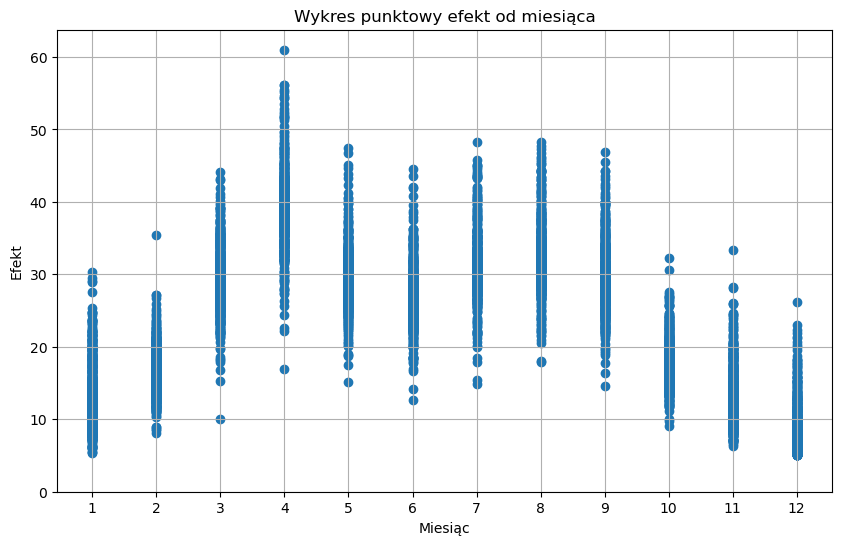

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(final_df['miesiac_x'], final_df['efekt'])
plt.title("Wykres punktowy efekt od miesiąca")
plt.xlabel("Miesiąc")
plt.ylabel("Efekt")
plt.grid(True)

plt.xticks(range(int(final_df['miesiac_x'].min()), int(final_df['miesiac_x'].max()) + 1, 1))
plt.yticks(range(0, int(final_df['efekt'].max()) + 1, 10))

plt.show()

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

X = final_df[['miesiac_x', 'moc', 'dlugosc', 'szerokosc', 'naslonecznienie', 'temperatura']]
y = final_df['efekt']

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Ponowne trenowanie najlepszego modelu
best_model = MLPRegressor(hidden_layer_sizes=(250, 260), max_iter=1000, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Ocena modelu na zbiorze testowym
y_pred = best_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
e_var_test = explained_variance_score(y_test, y_pred)

# Ocena modelu na zbiorze treningowym
y_pred_train = best_model.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
e_var_train = explained_variance_score(y_train, y_pred_train)

# Wydruk wyników
print("Najlepszy model na zbiorze testowym:")
print("Mean Squared Error:", mse_test)
print("R-squared:", r2_test)
print("Mean Absolute Error:", mae_test)
print("Explained Variance Score:", e_var_test)

print("= = = = =")

print("Najlepszy model na zbiorze treningowym:")
print("Mean Squared Error:", mse_train)
print("R-squared:", r2_train)
print("Mean Absolute Error:", mae_train)
print("Explained Variance Score:", e_var_train)


Najlepszy model na zbiorze testowym:
Mean Squared Error: 16.323602962992073
R-squared: 0.8394724404863275
Mean Absolute Error: 2.9614573975400194
Explained Variance Score: 0.8400936928074577
= = = = =
Najlepszy model na zbiorze treningowym:
Mean Squared Error: 15.612779008691781
R-squared: 0.8468215402775033
Mean Absolute Error: 2.910288299154812
Explained Variance Score: 0.8468432698150861


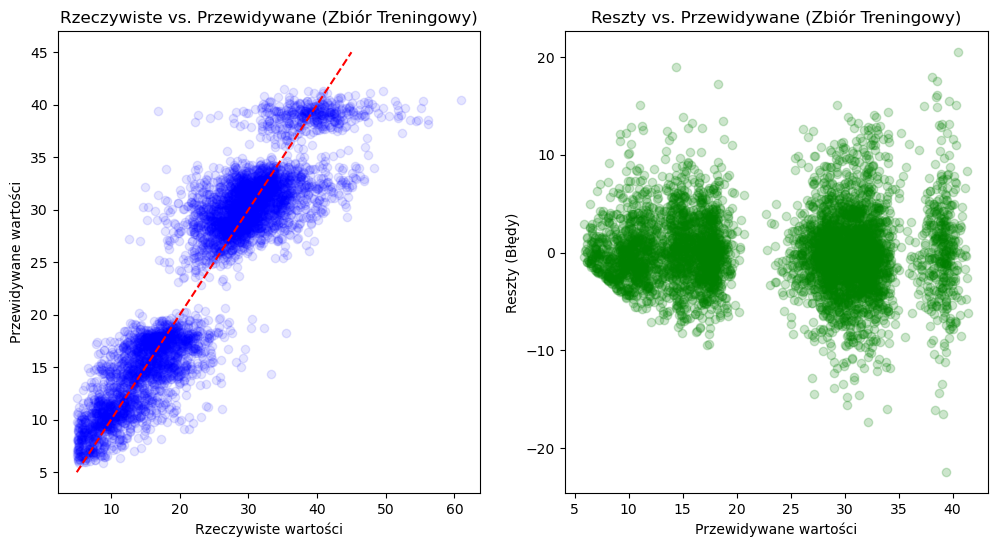

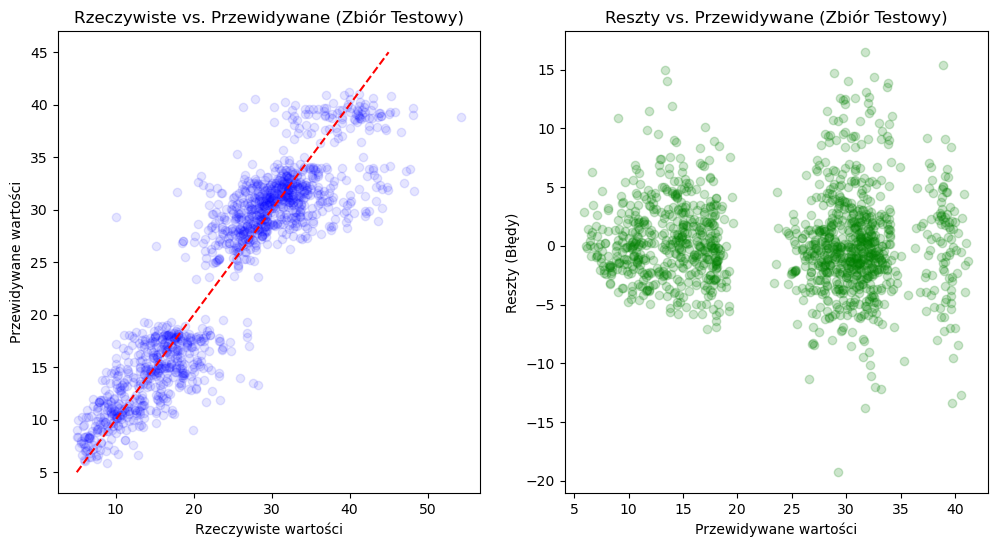

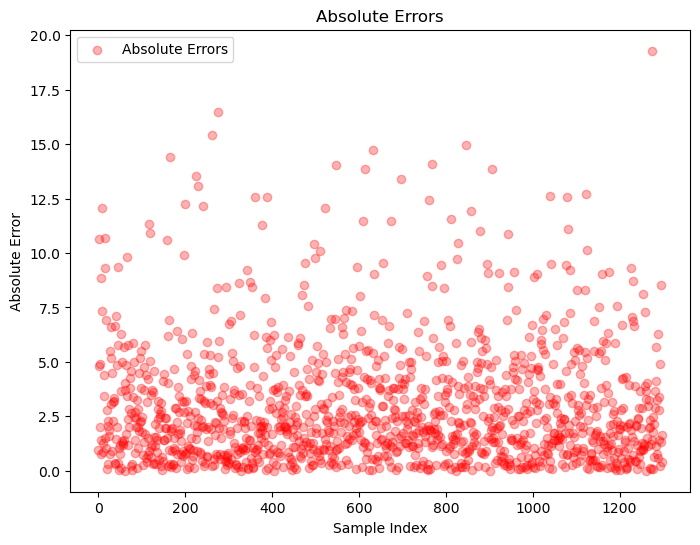

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Wykresy do oceny modelu
plt.figure(figsize=(12, 6))

# Wykres rzeczywistych vs. przewidywanych wartości dla zbioru treningowego
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.1, color='blue')
plt.plot([5, 45], [5, 45], color='red', linestyle='--')
plt.xlabel("Rzeczywiste wartości")
plt.ylabel("Przewidywane wartości")
plt.title("Rzeczywiste vs. Przewidywane (Zbiór Treningowy)")

# Wykres residuów (błędów) dla zbioru treningowego
plt.subplot(1, 2, 2)
residuals = y_train - y_pred_train
plt.scatter(y_pred_train, residuals, alpha=0.2, color='green')
plt.xlabel("Przewidywane wartości")
plt.ylabel("Reszty (Błędy)")
plt.title("Reszty vs. Przewidywane (Zbiór Treningowy)")

plt.savefig("wykresy_treningowy.png")

plt.show()

# Wykresy dla zbioru testowego
plt.figure(figsize=(12, 6))

# Wykres rzeczywistych vs. przewidywanych wartości dla zbioru testowego
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.1, color='blue')
plt.plot([5, 45], [5, 45], color='red', linestyle='--')
plt.xlabel("Rzeczywiste wartości")
plt.ylabel("Przewidywane wartości")
plt.title("Rzeczywiste vs. Przewidywane (Zbiór Testowy)")

# Wykres residuów (błędów) dla zbioru testowego
plt.subplot(1, 2, 2)
residuals_test = y_test - y_pred
plt.scatter(y_pred, residuals_test, alpha=0.2, color='green')  
plt.xlabel("Przewidywane wartości")
plt.ylabel("Reszty (Błędy)")
plt.title("Reszty vs. Przewidywane (Zbiór Testowy)")

plt.savefig("wykresy_testowy.png")
plt.show()

# Wykres błędu bezwzględnego
absolute_errors = np.abs(y_test - y_pred)
plt.figure(figsize=(8, 6))
plt.scatter(range(len(absolute_errors)), absolute_errors, marker='o', color='red', alpha=0.3, label='Absolute Errors') 
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.title('Absolute Errors')
plt.legend()

plt.savefig("wykres_bledy_na_test.png")
plt.show()




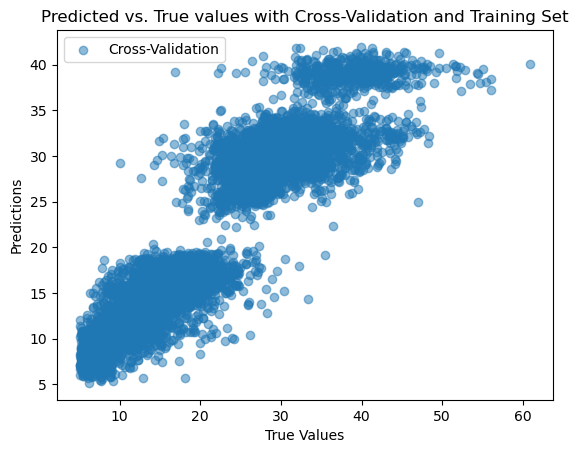

Model z użyciem walidacji krzyżowej:
Mean Squared Error: 17.02195235930238
R-squared: 0.8327101495357851
Mean Absolute Error: 3.042454341838911
Explained Variance Score: 0.8340404046902512


In [55]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# Wczytaj dane
X = final_df[['miesiac_x', 'moc', 'dlugosc', 'szerokosc', 'naslonecznienie', 'temperatura']]
y = final_df['efekt']

# Standaryzacja danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Utwórz model
model = MLPRegressor(hidden_layer_sizes=(250, 260), max_iter=1000, random_state=42)

# Walidacja krzyżowa
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prognozy na zbiorze testowym z użyciem walidacji krzyżowej
y_pred_cv = cross_val_predict(model, X_scaled, y, cv=kf)

# Ocena modelu na zbiorze testowym z użyciem walidacji krzyżowej
scores_cv = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
mse_cv = -np.mean(scores_cv)
r2_cv = np.mean(cross_val_score(model, X_scaled, y, cv=kf, scoring='r2'))
mae_cv = -np.mean(cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error'))
e_var_cv = np.mean(cross_val_score(model, X_scaled, y, cv=kf, scoring='explained_variance'))

# Wizualizacja wyników
plt.scatter(y, y_pred_cv, alpha=0.5, label='Cross-Validation')
plt.title('Predicted vs. True values with Cross-Validation and Training Set')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

# Wydruk wyników
print("Model z użyciem walidacji krzyżowej:")
print("Mean Squared Error:", mse_cv)
print("R-squared:", r2_cv)
print("Mean Absolute Error:", mae_cv)
print("Explained Variance Score:", e_var_cv)
